## EN 520.665 Machine Perception Project 1
#### Yu-Chun(Arthur) Ku, Ching-Yang(Austin) Huang
##### yck4@jh.edu, chuan120@jh.edu

### AlexNet CIFAR-10 model training and attack

In [10]:
import torch.optim as optim
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

from easydict import EasyDict as edict
import argparse

from AlexNet import AlexNet
from misc import progress_bar

Here we import AlexNet to train our model

In [11]:
model = AlexNet()
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [12]:
class Solver(object):
    def __init__(self, config):
        self.model = None
        self.lr = config.lr
        self.epochs = config.epoch
        self.train_batch_size = config.trainBatchSize
        self.test_batch_size = config.testBatchSize
        self.criterion = None
        self.optimizer = None
        self.scheduler = None
        self.device = None
        self.train_loader = None
        self.test_loader = None

    def load_data(self):
        train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
        test_transform = transforms.Compose([transforms.ToTensor()])
        train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        self.train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=self.train_batch_size, shuffle=True)
        test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        self.test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=self.test_batch_size, shuffle=False)

    def load_model(self):
        self.device = torch.device("mps")

        self.model = AlexNet().to(self.device)
        #self.model = GoogLeNet().to(self.device)

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[75, 150], gamma=0.5)
        self.criterion = nn.CrossEntropyLoss().to(self.device)

    def train(self):
        print("train:")
        self.model.train()
        train_loss = 0
        train_correct = 0
        total = 0

        for batch_num, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()
            prediction = torch.max(output, 1)  # second param "1" represents the dimension to be reduced
            total += target.size(0)

            # train_correct incremented by one if predicted right
            train_correct += np.sum(prediction[1].cpu().numpy() == target.cpu().numpy())

            progress_bar(batch_num, len(self.train_loader), 'Loss: %.4f | Acc: %.3f%% (%d/%d)'
                         % (train_loss / (batch_num + 1), 100. * train_correct / total, train_correct, total))

        return train_loss, train_correct / total

    def test(self):
        print("test:")
        self.model.eval()
        test_loss = 0
        test_correct = 0
        total = 0

        with torch.no_grad():
            for batch_num, (data, target) in enumerate(self.test_loader):
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = self.criterion(output, target)
                test_loss += loss.item()
                prediction = torch.max(output, 1)
                total += target.size(0)
                test_correct += np.sum(prediction[1].cpu().numpy() == target.cpu().numpy())

                progress_bar(batch_num, len(self.test_loader), 'Loss: %.4f | Acc: %.3f%% (%d/%d)'
                             % (test_loss / (batch_num + 1), 100. * test_correct / total, test_correct, total))

        return test_loss, test_correct / total

    def save(self):
        model_out_path = "model.pth"
        torch.save(self.model, model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))

    def run(self):
        self.load_data()
        self.load_model()
        accuracy = 0
        for epoch in range(1, self.epochs + 1):
            print("\n===> epoch: %d/100" % epoch)
            train_result = self.train()
            print(train_result)
            self.scheduler.step()
        test_result = self.test()
        accuracy = max(accuracy, test_result[1])
        print("===> BEST ACC. PERFORMANCE: %.3f%%" % (accuracy * 100))
        self.save()

In [13]:
# parser = argparse.ArgumentParser(description="cifar-10 with PyTorch")
# parser.add_argument('--lr', default=0.001, type=float, help='learning rate')
# parser.add_argument('--epoch', default=200, type=int, help='number of epochs tp train for')
# parser.add_argument('--trainBatchSize', default=100, type=int, help='training batch size')
# parser.add_argument('--testBatchSize', default=100, type=int, help='testing batch size')
def main():
    args = edict({
        "lr": 0.001,
        "epoch": 100,
        "trainBatchSize": 100,
        "testBatchSize": 100
    })


    solver = Solver(args)
    solver.run()

In [5]:
main()

Files already downloaded and verified
Files already downloaded and verified

===> epoch: 1/100
train:
 500/500 [================================================================================>]  Step: 65ms | Tot: 33s665ms | Loss: 1.7518 | Acc: 32.428% (16214/50000)========>....................................................................]  Step: 66ms | Tot: 5s60ms | Loss: 2.1873 | Acc: 14.514% (1074/7400) [===============>................................................................]  Step: 65ms | Tot: 6s669ms | Loss: 2.1417 | Acc: 15.847% (1553/9800) [=================>..............................................................]  Step: 66ms | Tot: 7s267ms | Loss: 2.1258 | Acc: 16.327% (1747/10700) [====================>...........................................................]  Step: 66ms | Tot: 8s646ms | Loss: 2.0951 | Acc: 17.307% (2198/12700) [=====================>..........................................................]  Step: 68ms | Tot: 9s189ms | Loss: 2.0810 | Ac

 500/500 [================================================================================>]  Step: 66ms | Tot: 33s183ms | Loss: 0.7299 | Acc: 74.818% (37409/50000)====>........................................................................]  Step: 67ms | Tot: 2s910ms | Loss: 0.7244 | Acc: 75.523% (3323/4400) [=======>........................................................................]  Step: 66ms | Tot: 2s976ms | Loss: 0.7235 | Acc: 75.600% (3402/4500) [==========>.....................................................................]  Step: 68ms | Tot: 4s231ms | Loss: 0.7336 | Acc: 75.156% (4810/6400) [==========>.....................................................................]  Step: 66ms | Tot: 4s364ms | Loss: 0.7313 | Acc: 75.152% (4960/6600) [===========>....................................................................]  Step: 66ms | Tot: 4s632ms | Loss: 0.7280 | Acc: 75.214% (5265/7000) [=================>.............................................................

 500/500 [================================================================================>]  Step: 72ms | Tot: 33s546ms | Loss: 0.4825 | Acc: 83.344% (41672/50000)............................................................................]  Step: 64ms | Tot: 1s140ms | Loss: 0.4633 | Acc: 84.611% (1523/1800) [===================>............................................................]  Step: 66ms | Tot: 7s955ms | Loss: 0.4556 | Acc: 84.233% (10108/12000) [===================>............................................................]  Step: 66ms | Tot: 8s21ms | Loss: 0.4563 | Acc: 84.198% (10188/12100) [====================>...........................................................]  Step: 70ms | Tot: 8s555ms | Loss: 0.4534 | Acc: 84.202% (10862/12900) [====================>...........................................................]  Step: 65ms | Tot: 8s620ms | Loss: 0.4534 | Acc: 84.200% (10946/13000) [============================>............................................

 500/500 [================================================================================>]  Step: 64ms | Tot: 33s570ms | Loss: 0.4113 | Acc: 85.924% (42962/50000)=>...........................................................................]  Step: 67ms | Tot: 2s27ms | Loss: 0.3695 | Acc: 87.484% (2712/3100) [============>...................................................................]  Step: 67ms | Tot: 5s193ms | Loss: 0.3806 | Acc: 87.282% (6808/7800) [=============>..................................................................]  Step: 66ms | Tot: 5s663ms | Loss: 0.3801 | Acc: 87.188% (7411/8500) [==============>.................................................................]  Step: 69ms | Tot: 6s190ms | Loss: 0.3877 | Acc: 86.892% (8081/9300) [======================>.........................................................]  Step: 67ms | Tot: 9s262ms | Loss: 0.3938 | Acc: 86.449% (11930/13800) [=============================>................................................

 500/500 [================================================================================>]  Step: 62ms | Tot: 31s850ms | Loss: 0.2922 | Acc: 90.168% (45084/50000)=========>...................................................................]  Step: 67ms | Tot: 4s732ms | Loss: 0.2605 | Acc: 91.307% (6848/7500) [============>...................................................................]  Step: 65ms | Tot: 4s932ms | Loss: 0.2616 | Acc: 91.295% (7121/7800) [========================================>.......................................]  Step: 66ms | Tot: 16s251ms | Loss: 0.2720 | Acc: 90.815% (23067/25400)
(146.12486294656992, 0.90168)

===> epoch: 43/100
train:
 500/500 [================================================================================>]  Step: 63ms | Tot: 31s716ms | Loss: 0.2947 | Acc: 89.806% (44903/50000)[=========================================================>......................]  Step: 62ms | Tot: 22s769ms | Loss: 0.2905 | Acc: 89.967% (32478/36100) [====

 500/500 [================================================================================>]  Step: 63ms | Tot: 31s619ms | Loss: 0.2043 | Acc: 93.308% (46654/50000)===========>.................................................................]  Step: 65ms | Tot: 5s492ms | Loss: 0.2070 | Acc: 93.227% (8204/8800) [==============================================>.................................]  Step: 70ms | Tot: 18s518ms | Loss: 0.2044 | Acc: 93.287% (27333/29300) [===============================================>................................]  Step: 67ms | Tot: 18s855ms | Loss: 0.2037 | Acc: 93.332% (27813/29800)
(102.17180896177888, 0.93308)

===> epoch: 58/100
train:
 500/500 [================================================================================>]  Step: 66ms | Tot: 32s912ms | Loss: 0.2229 | Acc: 92.662% (46331/50000)[========================================>.......................................]  Step: 66ms | Tot: 16s547ms | Loss: 0.2084 | Acc: 93.188% (23763/25500) [=

 500/500 [================================================================================>]  Step: 67ms | Tot: 33s382ms | Loss: 0.2140 | Acc: 92.808% (46404/50000)=>...........................................................................]  Step: 66ms | Tot: 1s862ms | Loss: 0.1784 | Acc: 93.690% (2717/2900) [=========>......................................................................]  Step: 66ms | Tot: 3s856ms | Loss: 0.1766 | Acc: 93.746% (5531/5900) [=========>......................................................................]  Step: 67ms | Tot: 4s57ms | Loss: 0.1758 | Acc: 93.758% (5813/6200) [==========>.....................................................................]  Step: 67ms | Tot: 4s258ms | Loss: 0.1751 | Acc: 93.785% (6096/6500) [==========>.....................................................................]  Step: 66ms | Tot: 4s391ms | Loss: 0.1759 | Acc: 93.776% (6283/6700) [=================>..............................................................

 500/500 [================================================================================>]  Step: 66ms | Tot: 33s311ms | Loss: 0.1988 | Acc: 93.364% (46682/50000)>............................................................................]  Step: 66ms | Tot: 1s199ms | Loss: 0.1892 | Acc: 93.842% (1783/1900) [====>...........................................................................]  Step: 66ms | Tot: 1s598ms | Loss: 0.1822 | Acc: 94.000% (2350/2500) [======>.........................................................................]  Step: 67ms | Tot: 2s732ms | Loss: 0.1809 | Acc: 93.929% (3945/4200) [=======>........................................................................]  Step: 66ms | Tot: 2s865ms | Loss: 0.1782 | Acc: 94.023% (4137/4400) [=================>..............................................................]  Step: 67ms | Tot: 7s178ms | Loss: 0.1867 | Acc: 93.807% (10225/10900) [=================>...........................................................

 500/500 [================================================================================>]  Step: 66ms | Tot: 33s478ms | Loss: 0.1950 | Acc: 93.580% (46790/50000).......................................................................]  Step: 65ms | Tot: 132ms | Loss: 0.1754 | Acc: 93.333% (280/300) [==>.............................................................................]  Step: 66ms | Tot: 797ms | Loss: 0.1905 | Acc: 93.769% (1219/1300) [===>............................................................................]  Step: 67ms | Tot: 1s330ms | Loss: 0.1949 | Acc: 93.762% (1969/2100) [=====>..........................................................................]  Step: 67ms | Tot: 2s130ms | Loss: 0.1885 | Acc: 93.939% (3100/3300) [======>.........................................................................]  Step: 66ms | Tot: 2s530ms | Loss: 0.1796 | Acc: 94.154% (3672/3900) [==========>.....................................................................]  Step: 67

 500/500 [================================================================================>]  Step: 67ms | Tot: 33s998ms | Loss: 0.1792 | Acc: 94.142% (47071/50000)>............................................................................]  Step: 66ms | Tot: 1s555ms | Loss: 0.2031 | Acc: 93.625% (2247/2400) [========>.......................................................................]  Step: 66ms | Tot: 3s301ms | Loss: 0.1956 | Acc: 93.620% (4681/5000) [===============>................................................................]  Step: 66ms | Tot: 6s403ms | Loss: 0.1858 | Acc: 93.979% (9022/9600) [================>...............................................................]  Step: 67ms | Tot: 6s740ms | Loss: 0.1845 | Acc: 93.990% (9493/10100) [================>...............................................................]  Step: 66ms | Tot: 7s8ms | Loss: 0.1846 | Acc: 93.962% (9866/10500) [========================>......................................................

 500/500 [================================================================================>]  Step: 65ms | Tot: 33s194ms | Loss: 0.1715 | Acc: 94.522% (47261/50000)====>........................................................................]  Step: 67ms | Tot: 2s975ms | Loss: 0.1496 | Acc: 95.109% (4375/4600) [========>.......................................................................]  Step: 66ms | Tot: 3s636ms | Loss: 0.1496 | Acc: 95.143% (5328/5600) [============>...................................................................]  Step: 67ms | Tot: 4s893ms | Loss: 0.1465 | Acc: 95.213% (7141/7500) [=======================>........................................................]  Step: 67ms | Tot: 9s688ms | Loss: 0.1489 | Acc: 95.163% (13989/14700) [===========================>....................................................]  Step: 66ms | Tot: 11s288ms | Loss: 0.1501 | Acc: 95.123% (16266/17100) [===========================>..............................................

 500/500 [================================================================================>]  Step: 67ms | Tot: 33s121ms | Loss: 0.0727 | Acc: 97.648% (48824/50000)=====================>..........................................................]  Step: 67ms | Tot: 8s793ms | Loss: 0.0737 | Acc: 97.714% (12996/13300) [=================================>..............................................]  Step: 66ms | Tot: 13s945ms | Loss: 0.0699 | Acc: 97.743% (20526/21000) [===================================================>............................]  Step: 67ms | Tot: 21s313ms | Loss: 0.0720 | Acc: 97.699% (31459/32200) [===========================================================>....................]  Step: 66ms | Tot: 24s628ms | Loss: 0.0723 | Acc: 97.671% (36236/37100) [===========================================================>....................]  Step: 66ms | Tot: 24s695ms | Loss: 0.0722 | Acc: 97.669% (36333/37200) [============================================================>.

 500/500 [================================================================================>]  Step: 66ms | Tot: 32s918ms | Loss: 0.0504 | Acc: 98.392% (49196/50000)[=========================================================>......................]  Step: 66ms | Tot: 23s683ms | Loss: 0.0543 | Acc: 98.263% (35473/36100) [==========================================================>.....................]  Step: 66ms | Tot: 23s817ms | Loss: 0.0543 | Acc: 98.259% (35668/36300) [==========================================================>.....................]  Step: 66ms | Tot: 23s951ms | Loss: 0.0541 | Acc: 98.266% (35867/36500) [============================================================>...................]  Step: 66ms | Tot: 24s688ms | Loss: 0.0534 | Acc: 98.282% (36954/37600) [====================================================================>...........]  Step: 67ms | Tot: 27s957ms | Loss: 0.0518 | Acc: 98.339% (41794/42500) [============================================================

After training, the result shows that the best accuracy performance is 73.320%

In [14]:
test_transform = transforms.Compose([transforms.ToTensor()])
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=1, shuffle=False)

Files already downloaded and verified


In [15]:
def fgsm_attack(input,epsilon,data_grad):
    pert_out = input + epsilon*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    return pert_out

In [16]:
def test(model,device,test_loader,epsilon,attack):
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] 
        if init_pred.item() != target.item():
            continue
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        if attack == "fgsm":
            perturbed_data = fgsm_attack(data,epsilon,data_grad)
        elif attack == "austin":
            perturbed_data = austin_attack(data)
        elif attack == "arthur":
            perturbed_data = arthur_attack(data,epsilon,data_grad)

        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    if epsilon:
        print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    else:
        print("Test Accuracy = {} / {} = {}".format(correct, len(test_loader), final_acc))

    return final_acc, adv_examples

Here we chose epsilons as 0, 0.007, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, and 0.3 since the accuracy dramatically dropped between 0 to 0.05. And after 0.05, the accuracy flattened. We chose several epsilon values, such as 0.1, 0.2, and 0.3, to show our observation and conclusion.

Test Accuracy = 7332 / 10000 = 0.7332
Epsilon: 0.005	Test Accuracy = 3649 / 10000 = 0.3649
Epsilon: 0.01	Test Accuracy = 2013 / 10000 = 0.2013
Epsilon: 0.02	Test Accuracy = 709 / 10000 = 0.0709
Epsilon: 0.03	Test Accuracy = 319 / 10000 = 0.0319
Epsilon: 0.05	Test Accuracy = 150 / 10000 = 0.015
Epsilon: 0.1	Test Accuracy = 205 / 10000 = 0.0205
Epsilon: 0.2	Test Accuracy = 366 / 10000 = 0.0366
Epsilon: 0.3	Test Accuracy = 502 / 10000 = 0.0502


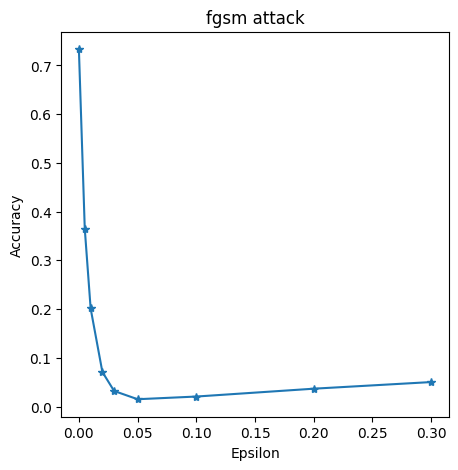

In [19]:
epsilons = [0,0.005, 0.01, 0.02, 0.03, 0.05,0.1,0.2,0.3]
accuracies = []
examples = []
device = torch.device("mps")
model = torch.load('./model.pth')
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, "fgsm")
    accuracies.append(acc)
    examples.append(ex)
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.title("fgsm attack")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [17]:
def austin_attack(input):
    pert_out = 1-input
    pert_out = torch.clamp(pert_out, 0, 1)
    return pert_out

Here we performed an attack and the accuracy dropped from 73.320% to 20.03%

In [18]:
device = torch.device("mps")
model = torch.load('./model.pth')
acc, ex = test(model, device, test_loader, [], "austin")

Test Accuracy = 2003 / 10000 = 0.2003


In [ ]:
def arthur_attack(input,epsilon,data_grad):
    iter=10
    decay_factor=1.0
    pert_out = input
    alpha = epsilon/iter
    g=0
    for i in range(iter-1):
        g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
        pert_out = pert_out + alpha*torch.sign(g)
        pert_out = torch.clamp(pert_out, 0, 1)
        if torch.norm((pert_out-input),p=float('inf')) > epsilon:
            break
    return pert_out

Here we performed another attack that the accuracy dropped from 73.320% to 20.03%